[[0.0091125  0.00434198 0.00322351 0.68075514 0.02068463 0.05518181
  0.0045514  0.05534793 0.00543125 0.01551023 0.         0.00447572
  0.         0.0047125  0.         0.06049883 0.00367966 0.
  0.04873296 0.00361945 0.         0.00471423 0.00465692 0.00598013
  0.00478923]
 [0.01185643 0.00596695 0.00460684 0.62666726 0.01430653 0.07478744
  0.00477898 0.07577585 0.01097381 0.0207526  0.         0.00566438
  0.         0.00556859 0.         0.02975974 0.00537862 0.
  0.07110015 0.00796896 0.         0.00681666 0.00661797 0.00518903
  0.00546314]
 [0.00612957 0.00440477 0.00574685 0.6236773  0.01070804 0.0940145
  0.00587729 0.08015269 0.00556487 0.02349581 0.         0.0041443
  0.         0.00542721 0.         0.0233113  0.0075459  0.00303349
  0.06507433 0.00812357 0.         0.00511882 0.00603667 0.00727219
  0.00514042]
 [0.01178787 0.00469238 0.00454416 0.7086084  0.00582954 0.05474288
  0.00290488 0.05612085 0.00649899 0.01767803 0.         0.00511994
  0.         0.00483713 

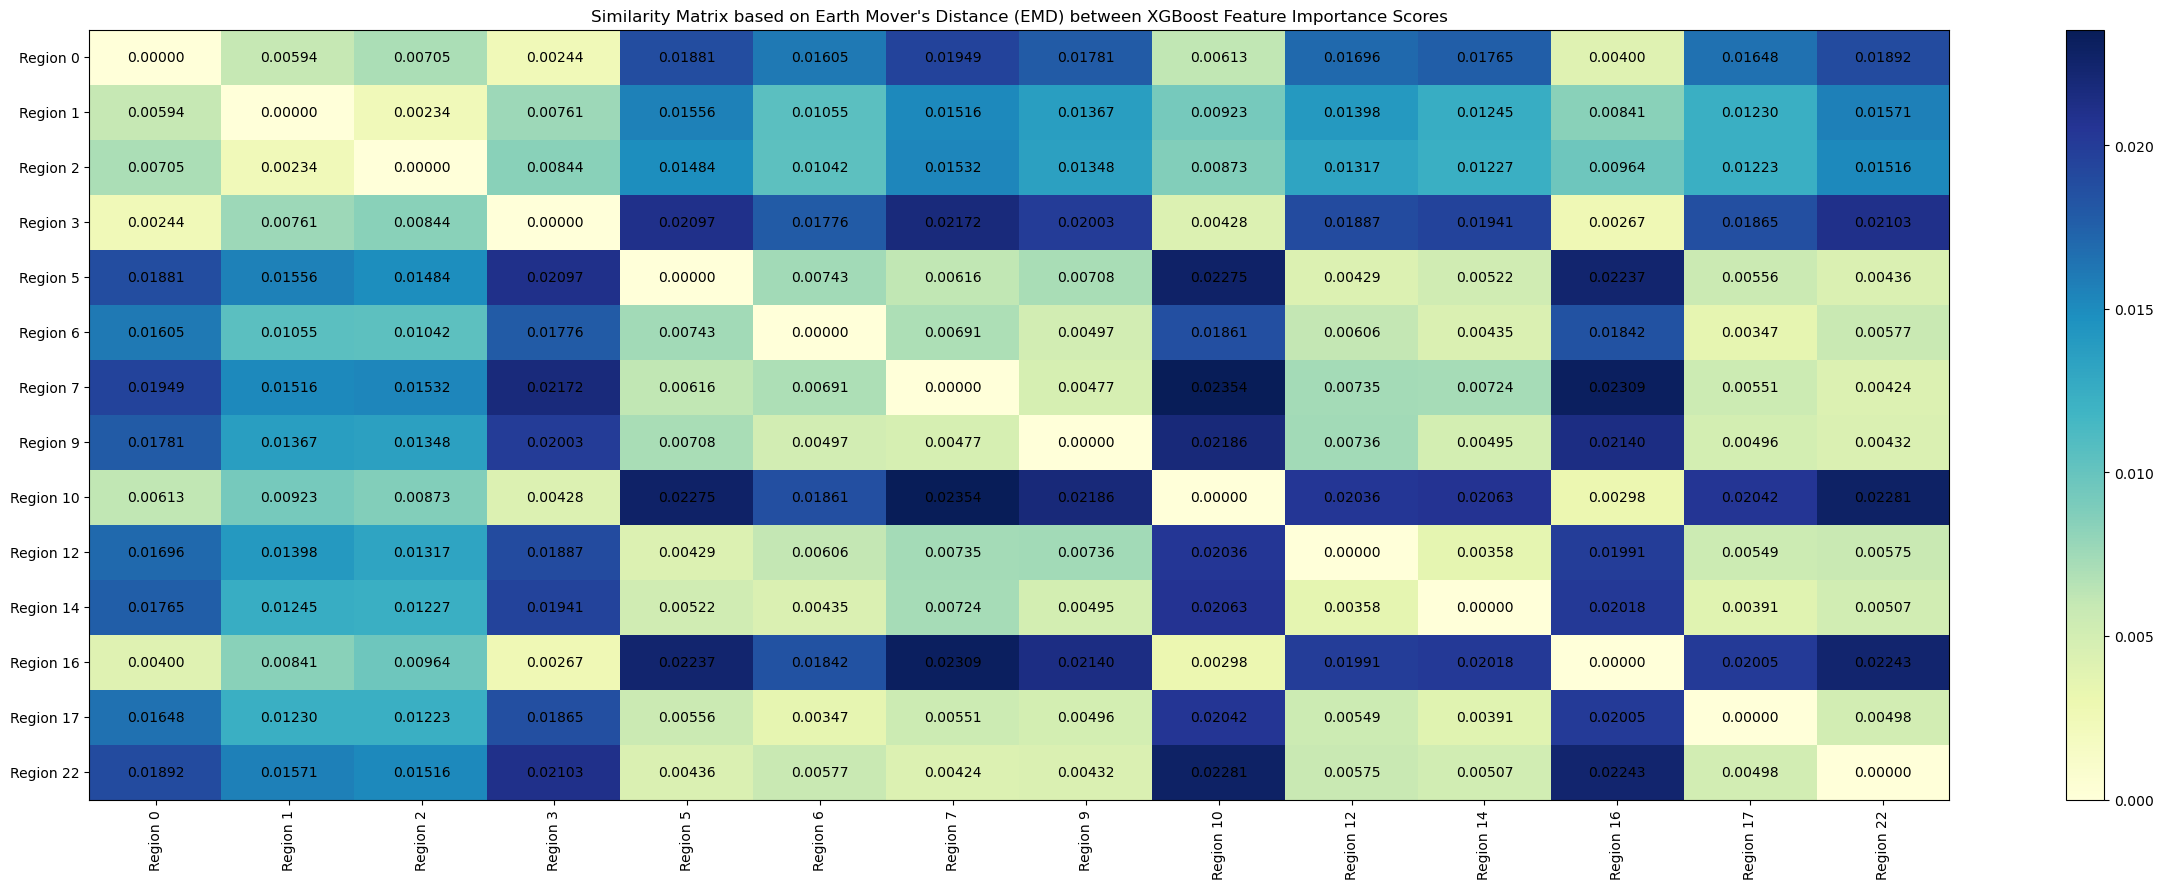

In [67]:
import pandas as pd
import networkx as nx
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from grakel.kernels import GraphletSampling
from grakel.utils import graph_from_networkx
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

# Step i: Reading Data and XGBoost Feature Importance

# Open the HDF5 file
file = h5py.File("market_data.h5", "r")

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']

# Initialize an empty list to store DataFrames from each sheet
dataframes = []

# Read and concatenate DataFrames from each sheet
for sheet_name in sheet_names:
    # Read the dataset using the current sheet name
    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)

    # Read the column names from the attributes
    column_names = file[sheet_name].attrs["columns"]

    # Assign column names to the dataset
    dataset.columns = column_names

    # Append the DataFrame to the list
    dataframes.append(dataset)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Replace "Region Index" with "Order Region"
df.rename(columns={"Region Index": "Order Region"}, inplace=True)

# Replace numbers with corresponding names using region_map
df["Order Region"] = df["Order Region"].map(region_map)




# Function to calculate EMD between two distributions
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# List to store XGBoost feature importance scores for each region
feature_importance_scores = []
# Copy the original DataFrame to avoid modifying the original data
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    # Store feature importance scores
    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))


# Reverse the label encoding to get the original region names
reverse_mapping = {v: k for k, v in region_map.items()}
# List to store region names
region_names = []
# Create t-SNE projections and store region names
for i, region in enumerate(df_cluster['Order Region'].unique()):

    region_names.append(f'Region {reverse_mapping.get(region, f"Unknown Region {region}")}')




for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(feature_importance_scores[i], feature_importance_scores[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value
 
similarity_matrix_xgboost



plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

# Add text annotations for each grid
for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()



In [77]:
from itertools import combinations

# Generate all possible combinations of regions for each submatrix size
submatrix_combinations = {}
for submatrix_size in range(1, num_regions + 1):
    combinations_list = []
    for combination in combinations(region_names, submatrix_size):
        combinations_list.append(list(combination))
    submatrix_combinations[submatrix_size] = combinations_list

# Calculate the average similarity for each combination and submatrix size
average_similarities = {}
for submatrix_size, combinations in submatrix_combinations.items():
    similarities = []
    for combination in combinations:
        similarity_sum = 0
        count = 0
        for i in range(len(combination)):
            for j in range(i + 1, len(combination)):
                region_idx1 = region_names.index(combination[i])
                region_idx2 = region_names.index(combination[j])
                similarity_sum += similarity_matrix_xgboost[region_idx1, region_idx2]
                count += 1
        average_similarity = similarity_sum / count if count > 0 else 0
        similarities.append(average_similarity)
    average_similarities[submatrix_size] = similarities

# Sort submatrix sizes based on average similarity values
sorted_submatrix_sizes = sorted(average_similarities.keys(), key=lambda x: sum(average_similarities[x]))

# Create a list of tuples with combination and average similarity
combo_avg_similarity = []
for submatrix_size, combinations in submatrix_combinations.items():
    for idx, combination in enumerate(combinations, start=1):
        avg_similarity = average_similarities[submatrix_size][idx - 1]
        combo_avg_similarity.append((combination, avg_similarity))

# Sort the list of tuples by average similarity
sorted_combo_avg_similarity = sorted(combo_avg_similarity, key=lambda x: x[1])

# Print the sorted combinations
for rank, (combination, avg_similarity) in enumerate(sorted_combo_avg_similarity, start=1):
    print(f"{rank}. {combination}: Average similarity = {avg_similarity:.5f}")



1. ['Region 0']: Average similarity = 0.00000
2. ['Region 1']: Average similarity = 0.00000
3. ['Region 2']: Average similarity = 0.00000
4. ['Region 3']: Average similarity = 0.00000
5. ['Region 5']: Average similarity = 0.00000
6. ['Region 6']: Average similarity = 0.00000
7. ['Region 7']: Average similarity = 0.00000
8. ['Region 9']: Average similarity = 0.00000
9. ['Region 10']: Average similarity = 0.00000
10. ['Region 12']: Average similarity = 0.00000
11. ['Region 14']: Average similarity = 0.00000
12. ['Region 16']: Average similarity = 0.00000
13. ['Region 17']: Average similarity = 0.00000
14. ['Region 22']: Average similarity = 0.00000
15. ['Region 1', 'Region 2']: Average similarity = 0.00234
16. ['Region 0', 'Region 3']: Average similarity = 0.00244
17. ['Region 3', 'Region 16']: Average similarity = 0.00267
18. ['Region 10', 'Region 16']: Average similarity = 0.00298
19. ['Region 0', 'Region 3', 'Region 16']: Average similarity = 0.00303
20. ['Region 3', 'Region 10', 'Reg

In [62]:
from sklearn.cluster import KMeans

# Number of clusters (you can adjust this based on your preference)
num_clusters = 3

# Reshape the feature importance scores to 2D array
X = np.array(feature_importance_scores)

# Apply K-means clustering to the feature importance scores for all regions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Display cluster labels for all regions along with region names
for region_name, label in zip(region_names, cluster_labels):
    print(f"{region_name} cluster label:", label)


Region 0 cluster label: 1
Region 1 cluster label: 1
Region 2 cluster label: 1
Region 3 cluster label: 1
Region 5 cluster label: 2
Region 6 cluster label: 0
Region 7 cluster label: 2
Region 9 cluster label: 0
Region 10 cluster label: 1
Region 12 cluster label: 2
Region 14 cluster label: 2
Region 16 cluster label: 1
Region 17 cluster label: 0
Region 22 cluster label: 2


/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

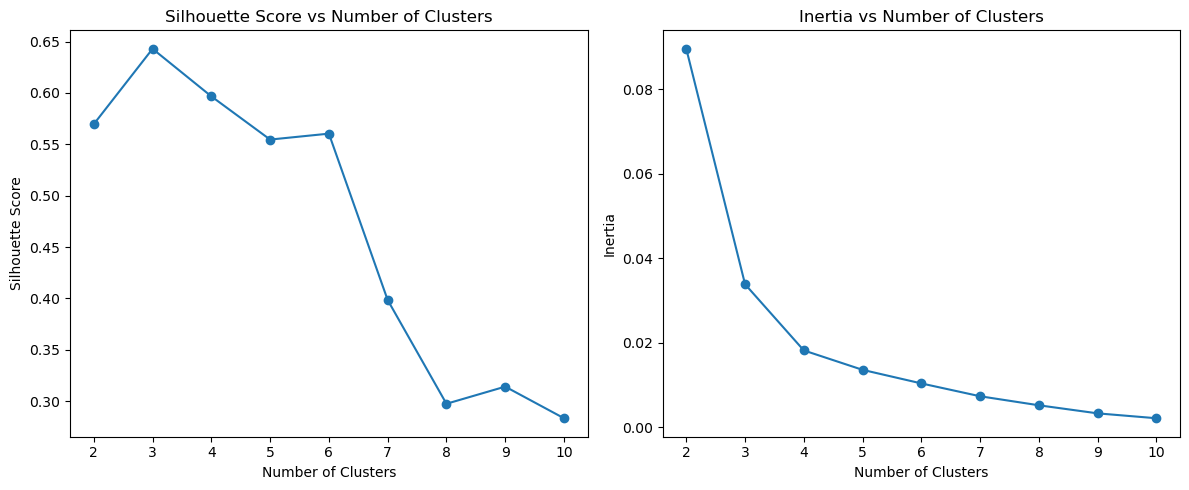

In [61]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Range of values for the number of clusters
min_clusters = 2
max_clusters = 10

# Initialize lists to store silhouette scores and inertias
silhouette_scores = []
inertias = []

# Calculate silhouette scores and inertias for different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette = silhouette_score(X, cluster_labels)
    inertia = kmeans.inertia_
    
    silhouette_scores.append(silhouette)
    inertias.append(inertia)

# Plot the silhouette scores and inertias for different numbers of clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(range(min_clusters, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()


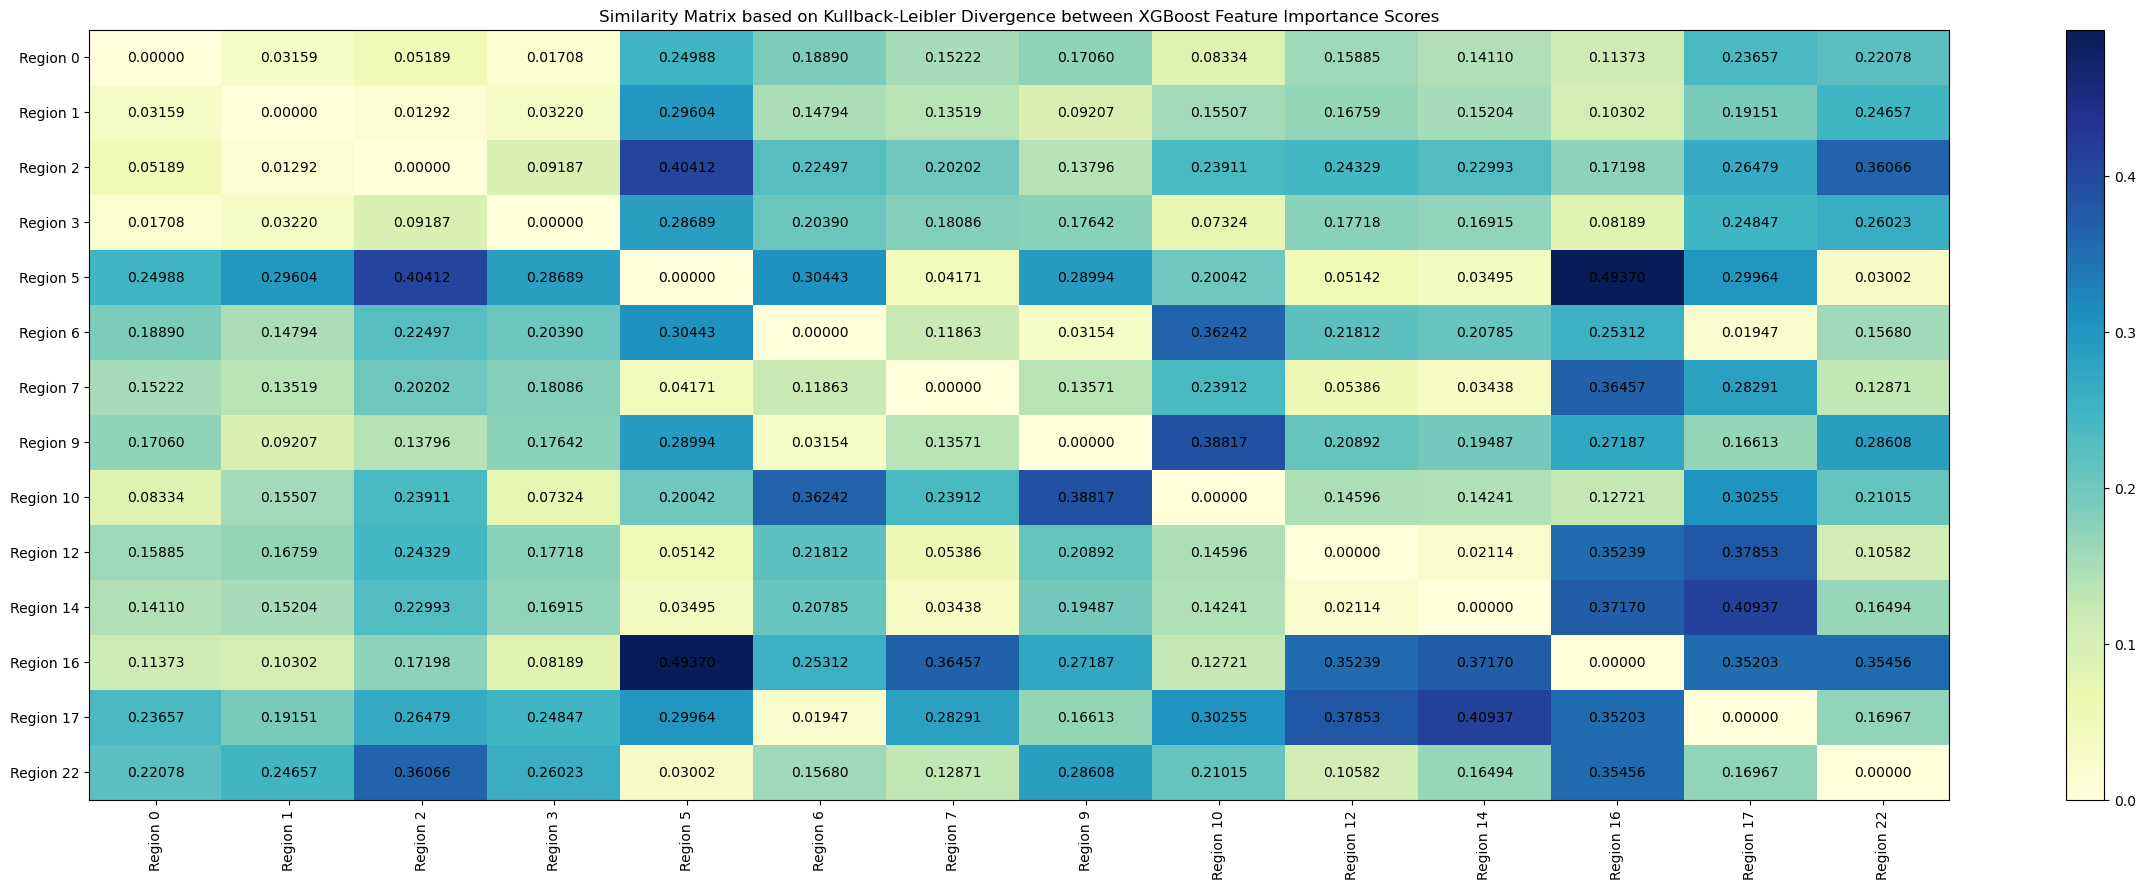

In [64]:
from scipy.stats import entropy

# List to store XGBoost feature importance scores for each region
feature_importance_scores = []

# Iterate over each region
for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values
    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    # Store feature importance scores
    feature_importance_scores.append(model.feature_importances_)

# Convert feature importance scores to NumPy array
feature_importance_scores = np.array(feature_importance_scores)

# Calculate the similarity matrix using KL divergence
num_regions = len(feature_importance_scores)
similarity_matrix_kl = np.zeros((num_regions, num_regions))

# Small epsilon value to add to the probabilities to avoid zero probabilities
epsilon = 1e-10

# Calculate the similarity matrix using KL divergence with epsilon added to probabilities
similarity_matrix_kl = np.zeros((num_regions, num_regions))

for i in range(num_regions):
    for j in range(i + 1, num_regions):
        # Add epsilon to the probability distributions
        p1 = feature_importance_scores[i] + epsilon
        p2 = feature_importance_scores[j] + epsilon
        
        # Normalize the probability distributions
        p1 /= np.sum(p1)
        p2 /= np.sum(p2)
        
        # Compute KL divergence between the normalized probability distributions
        kl_divergence = entropy(p1, p2)
        
        # Store the KL divergence in the similarity matrix
        similarity_matrix_kl[i, j] = kl_divergence
        similarity_matrix_kl[j, i] = kl_divergence

# Plot the similarity matrix
plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_kl, cmap="YlGnBu", interpolation='nearest', aspect='auto')

# Add text annotations for each grid
for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_kl[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Kullback-Leibler Divergence between XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()
